In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numba
import time 
from scipy import ndimage
from skimage.feature import peak_local_max

In [2]:
FOLDER="C:\\Users\\be34gof\\Downloads\\20220117"

In [3]:
assert os.path.exists(FOLDER)
processed_image_folder=os.path.join(FOLDER,"processed")

In [115]:
def remove_footer(img):
    footer_idx=(img.mean(1)[int(img.shape[0]/2):]>200).argmax()+int(img.shape[0]/2)
    return img[:footer_idx-1]

def scale_image(img):
    img=img - img.min()
    img=img/img.max()
    return img

def show_img(img,oimg=None):
    plt.figure(dpi=200)
    if oimg is not None:
        plt.imshow(oimg,cmap="plasma")
        plt.imshow(img,alpha=0.7)
    else:
        plt.imshow(img)
    plt.show()
    plt.close()


def convolute(img,func,d=1):
    conv_img=np.zeros_like(img)
    for x in range(img.shape[0]):
        x0=max(x-d,0)
        x1=min(x+d,img.shape[0])
        for y in range(img.shape[1]):
            y0=max(y-d,0)
            y1=min(y+d,img.shape[1])
            conv_img[x,y]=func(img[x0:x1,y0:y1])
    return conv_img

@numba.jit(nopython=True, parallel=False)
def std_convolute(img,d=1):
    conv_img=np.zeros_like(img)
    for x in range(img.shape[0]):
        x0=max(x-d,0)
        x1=min(x+d,img.shape[0])
        for y in range(img.shape[1]):
            y0=max(y-d,0)
            y1=min(y+d,img.shape[1])
            conv_img[x,y]=np.std(img[x0:x1,y0:y1])
    return conv_img

@numba.jit(nopython=True, parallel=False)
def min_convolute(img,d=1):
    conv_img=np.zeros_like(img)
    for x in range(img.shape[0]):
        x0=max(x-d,0)
        x1=min(x+d,img.shape[0])
        for y in range(img.shape[1]):
            y0=max(y-d,0)
            y1=min(y+d,img.shape[1])
            conv_img[x,y]=np.min(img[x0:x1,y0:y1])
    return conv_img


@numba.jit(nopython=True, parallel=False)
def mean_convolute(img,d=1):
    conv_img=np.zeros_like(img)
    for x in range(img.shape[0]):
        x0=max(x-d,0)
        x1=min(x+d,img.shape[0])
        for y in range(img.shape[1]):
            y0=max(y-d,0)
            y1=min(y+d,img.shape[1])
            conv_img[x,y]=np.mean(img[x0:x1,y0:y1])
    return conv_img

@numba.jit(nopython=True, parallel=False)
def median_convolute(img,d=1):
    conv_img=np.zeros_like(img)
    for x in range(img.shape[0]):
        x0=max(x-d,0)
        x1=min(x+d,img.shape[0])
        for y in range(img.shape[1]):
            y0=max(y-d,0)
            y1=min(y+d,img.shape[1])
            conv_img[x,y]=np.median(img[x0:x1,y0:y1])
    return conv_img

def bg_map(img,th=0.2):
    return img<(img.min()*(1-th) + img.max()*th)

def rm_bg(img,th=0.2):
    img=img.copy()
    img[bg_map(img,th=th)]=0
    return img
    
def timeit(f,*args,**kwargs):
    start = time.time()
    r=f(*args,**kwargs)
    end = time.time()
    print("Elapsed (with compilation) = %s" % (end - start))
    return r

def sample_subimages(img,w,h,n,return_indices=False):
    x0=w
    x1=img.shape[0]-h
    
    y0=h
    y1=img.shape[1]-h
    
    assert x1>x0
    assert y1>y0
    
    xs=np.random.rand(n)*(x1-x0) + x0
    ys=np.random.rand(n)*(y1-y0) + y0
    
    xr=np.arange(img.shape[0])
    yr=np.arange(img.shape[1])
    
    samples=[]
    for i in range(n):
        x=int(xs[i]-w/2)
        y=int(ys[i]-h/2)
        if return_indices:
            samples.append(np.stack(np.meshgrid(xr[x:x+w],yr[y:y+h]),axis=-1))
        else:
            samples.append(img[x:x+w,y:y+h])
        
    return samples

def h_blank_split(img,threshold=0.4):
    a=np.zeros(img.shape[0])
    for i in range(img.shape[0]):
        if img[i,:].max()<TH:
            img[i,:]=0
            a[i]=-1
        else:
            a[i]=1
    
    return np.array(a)

def v_blank_split(img,threshold=0.4):
    a=np.zeros(img.shape[1])
    for i in range(img.shape[1]):
        if img[:,i].max()<TH:
            img[:,i]=0
            a[i]=-1
        else:
            a[i]=1
    
    return np.array(a)

def h_sub_indices(img,threshold=0.4):
    x_borders=h_blank_split(img,threshold=threshold)
    with_particles=x_borders>=0
    particle_indices=np.arange(len(with_particles))[with_particles]
    splits =np.arange(len(particle_indices)-1)[np.diff(particle_indices) > 1]+1
    boarders = np.array([[a[0]-1,a[-1]+1] for a in np.split(particle_indices,splits) if len(a)>1])
    return boarders

def v_sub_indices(img,threshold=0.4):
    y_borders=v_blank_split(img,threshold=threshold)
    with_particles=x_borders>=0
    particle_indices=np.arange(len(with_particles))[with_particles]
    splits =np.arange(len(particle_indices)-1)[np.diff(particle_indices) > 1]+1
    boarders = np.array([[a[0]-1,a[-1]+1] for a in np.split(particle_indices,splits) if len(a)>1])
    return boarders

PE_230_01.tif


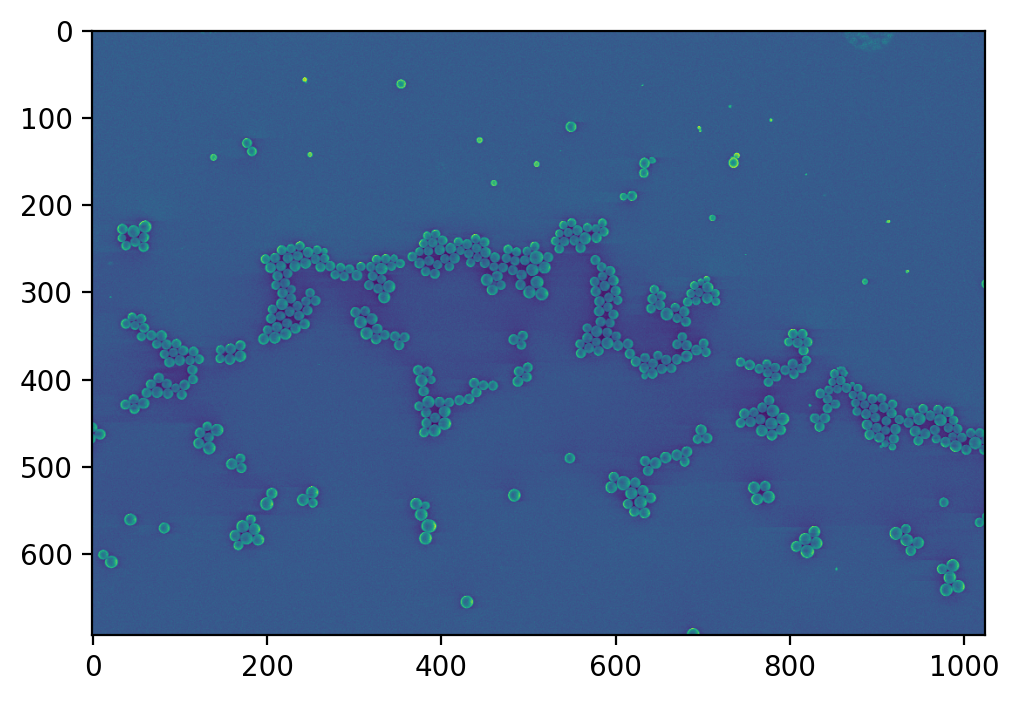

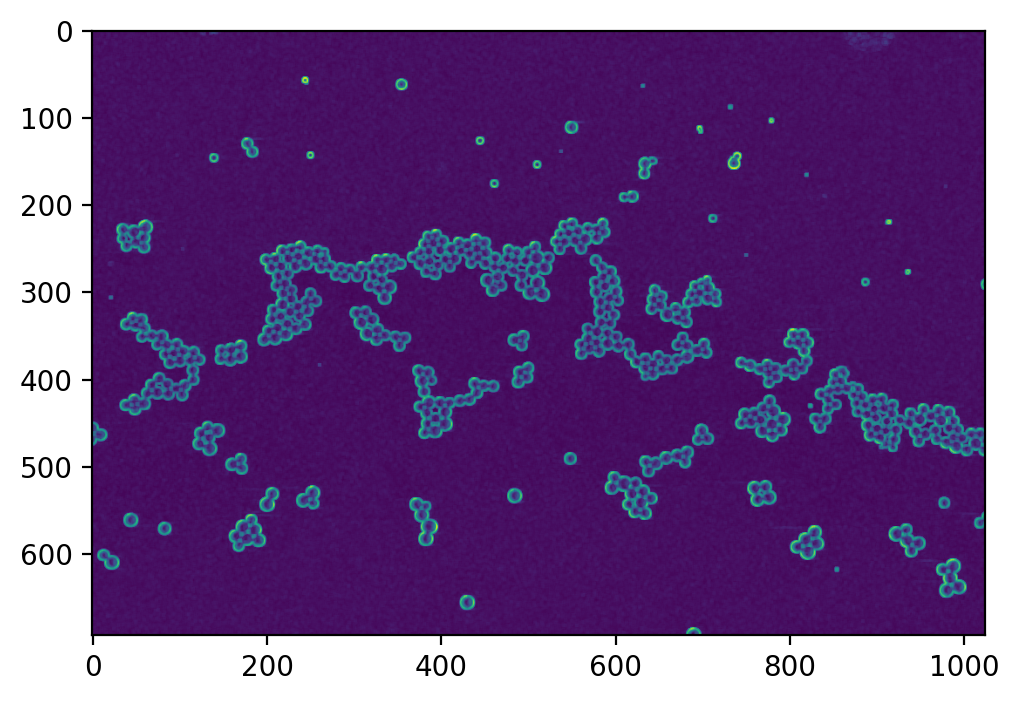

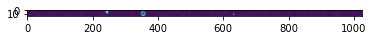

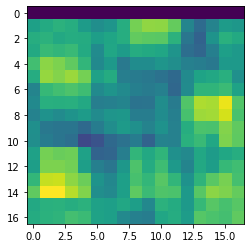

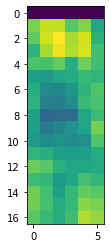

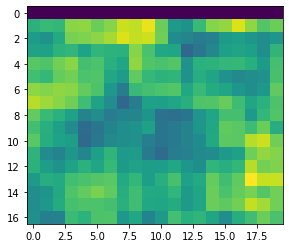

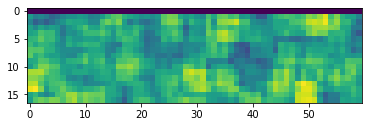

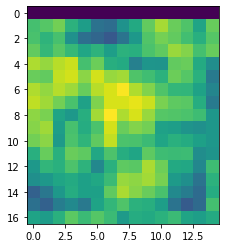

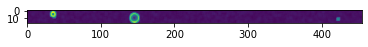

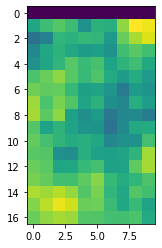

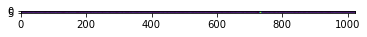

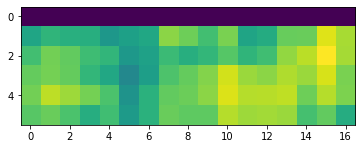

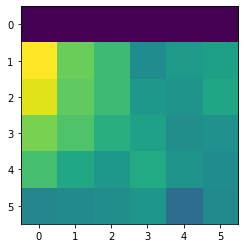

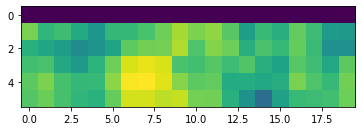

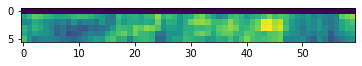

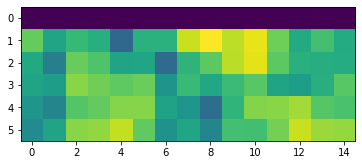

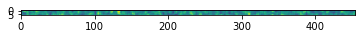

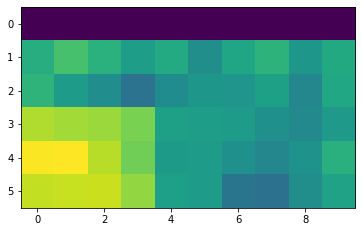

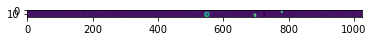

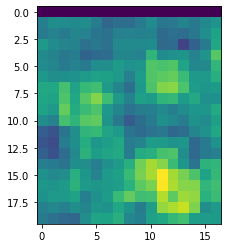

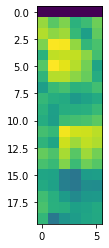

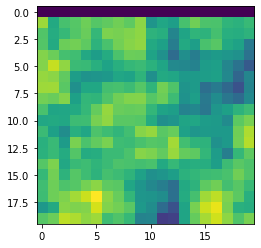

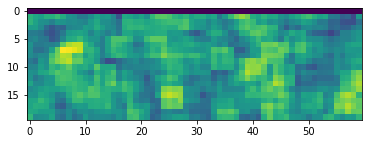

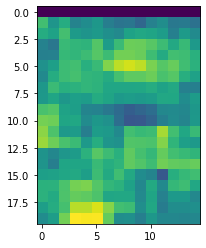

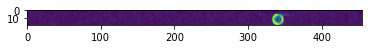

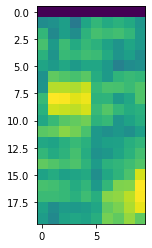

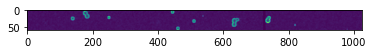

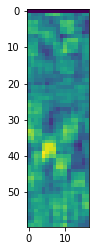

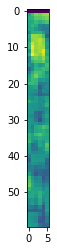

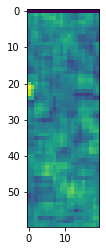

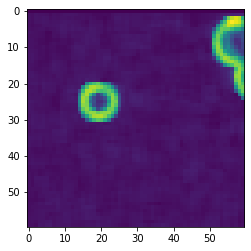

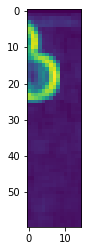

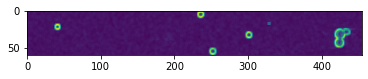

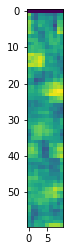

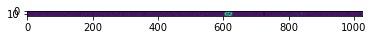

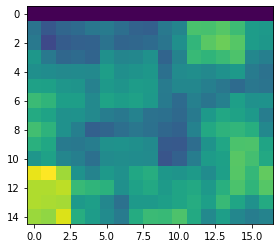

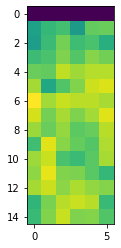

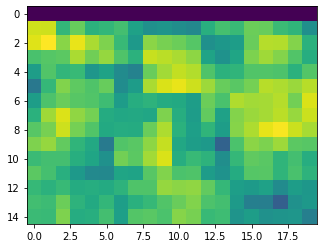

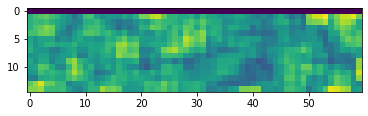

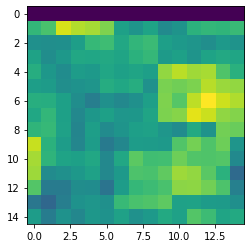

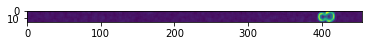

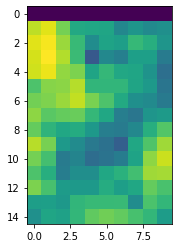

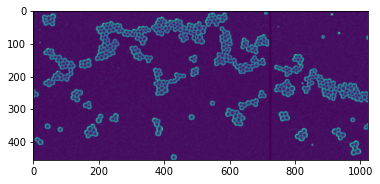

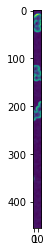

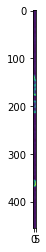

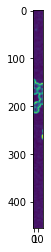

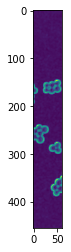

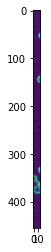

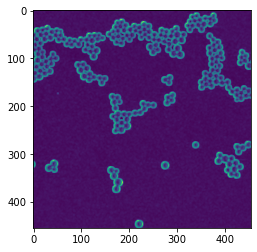

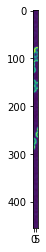

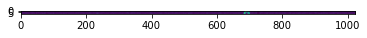

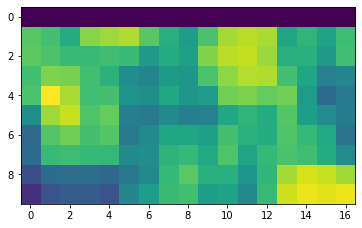

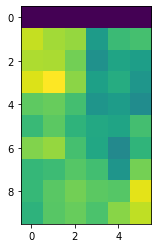

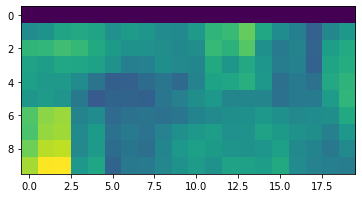

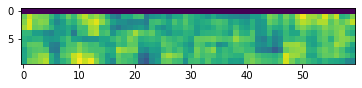

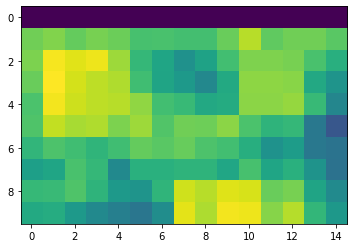

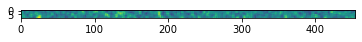

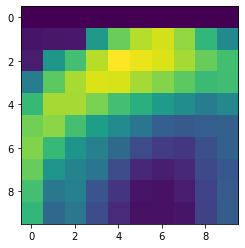

[[ 51  68]
 [ 84  90]
 [ 98 118]
 [120 180]
 [182 197]
 [209 664]
 [683 693]]


In [119]:
for fn in sorted(os.listdir(FOLDER)):
    if not fn.endswith(".tif"):
        continue
    print(fn)
    file = os.path.join(FOLDER,fn)
    im = Image.open(file)
    img = np.array(im)
    
    img = remove_footer(img)
    img = oimg = scale_image(img)
    
    show_img(img)
    
    img = scale_image(std_convolute(img,d=2))
    #simg1=img.copy()
    #img=rm_bg(img,th=0.
    show_img(img)

    TH=0.4
    
    for i in range(1):
        x_sub_indices = h_sub_indices(img)
        for xi in x_sub_indices:
            sub_img=img[xi[0]:xi[1],:]
            plt.imshow(sub_img)
            plt.show()
            plt.close()
            y_sub_indices = v_sub_indices(img)
            for yi in y_sub_indices:
                sub_sub_img=sub_img[:,yi[0]:yi[1]]
                plt.imshow(sub_sub_img)
                plt.show()
                plt.close()
        print(x_sub_indices)
#    x_borders=h_blank_split(img)
    
    #plt.close()
    #show_img(img)
    #bgm=bg_map(img)
    #bgm=(~bgm)
    
    #show_img(~bgm)
    #distance = ndimage.distance_transform_edt(bgm)
    #samples=sample_subimages(img,w=50,h=50,n=10,return_indices=True)
    #M=20
    #distance[distance>M]=M
    #img = scale_image(std_convolute(distance,d=2))
    #img[img>0.9]=0
    #img = scale_image(median_convolute(img,d=4))
    
    #bgm=bg_map(img)
    #img=oimg.copy()
    #img[bgm]=img[bgm].mean()
    
    #img = ndimage.distance_transform_edt(~bgm)
    #show_img(~bgm)
    #M=1
    #img[img>M]=M
    #show_img(img)
    
    #img = scale_image(std_convolute(img,d=2))+0.01
    #show_img(np.log(img))
    #show_img(img+simg1)
    #for s in samples:
    #    show_img(oimg[s[:,:,0],s[:,:,1]])
    break

[51 68]


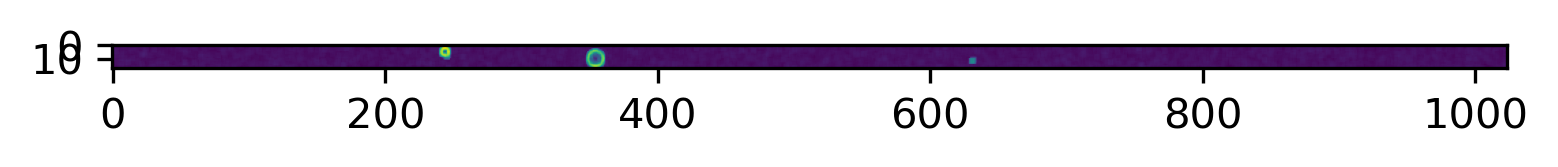

[84 90]


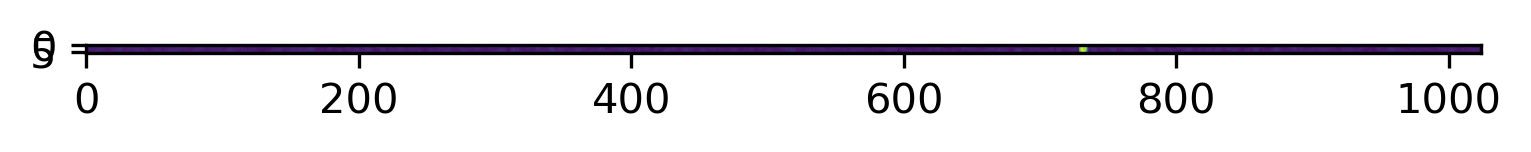

[ 98 118]


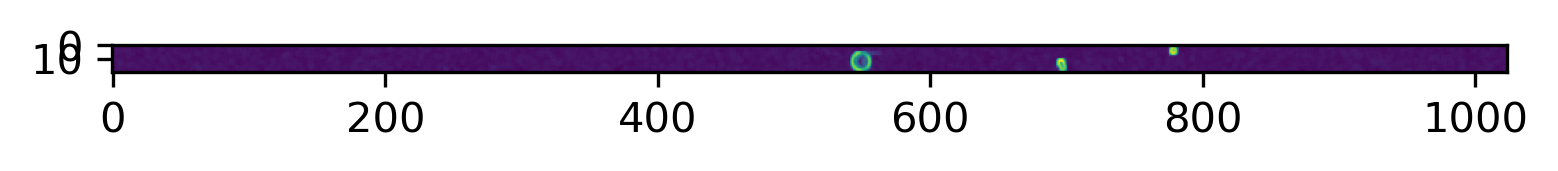

[120 180]


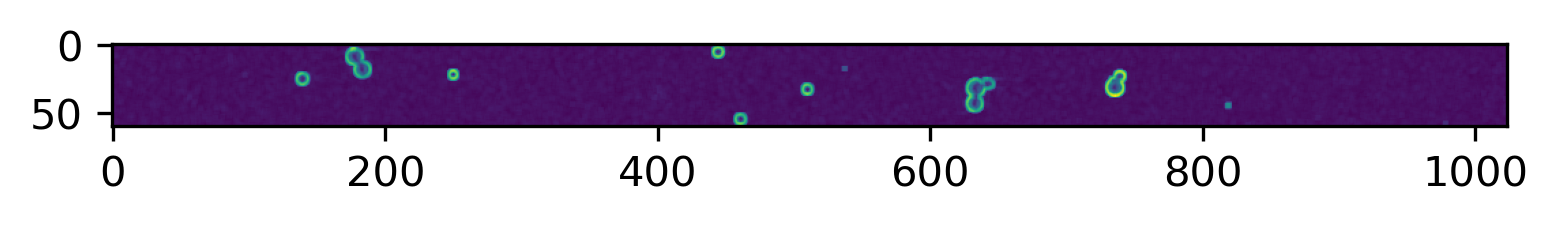

[182 197]


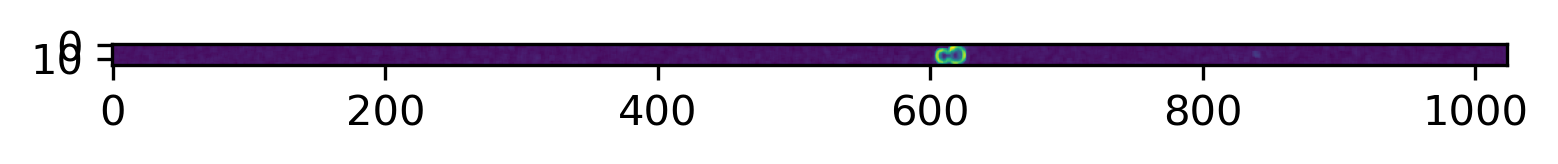

[209 664]


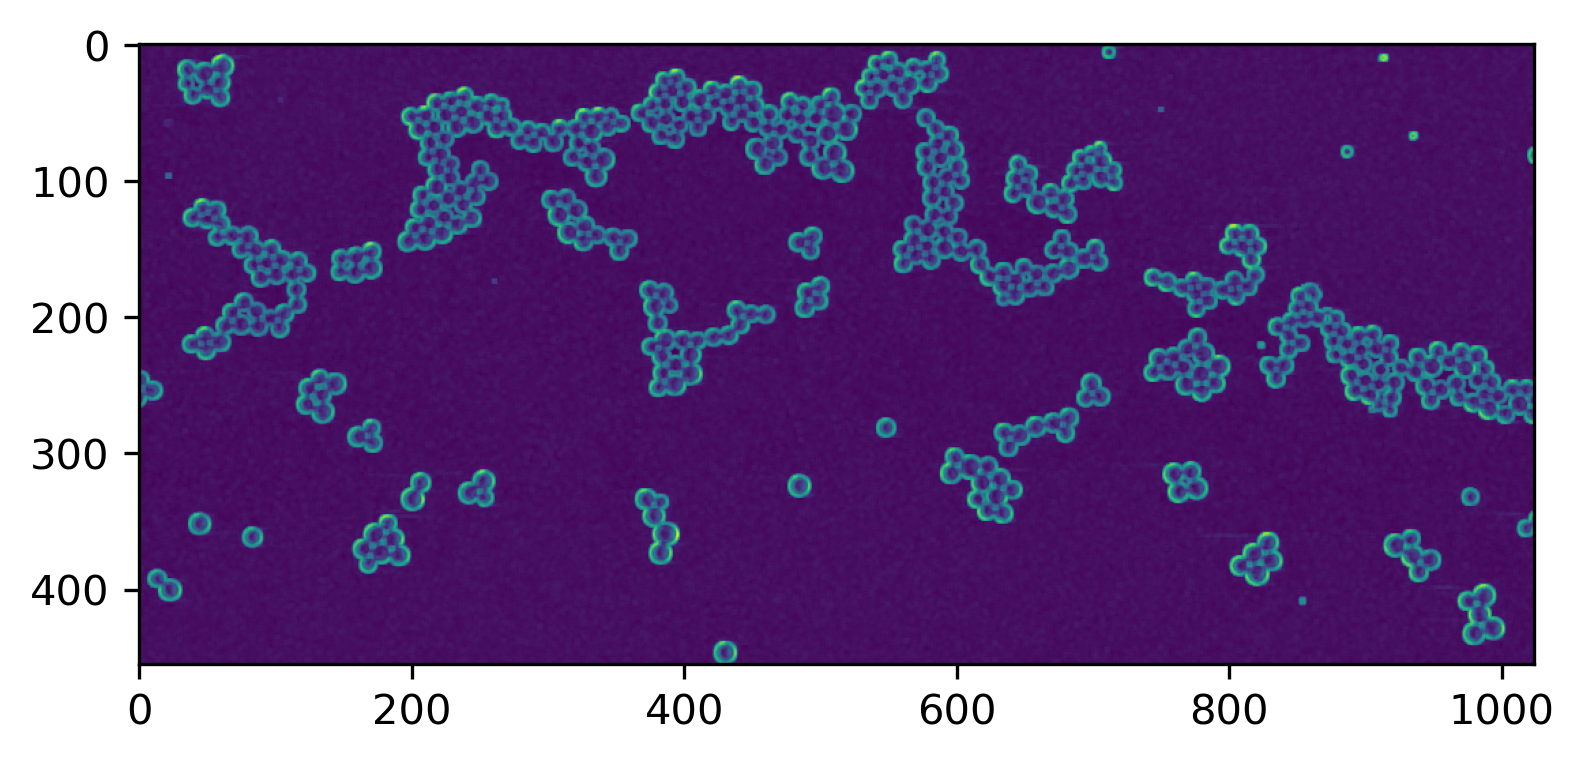

[683 693]


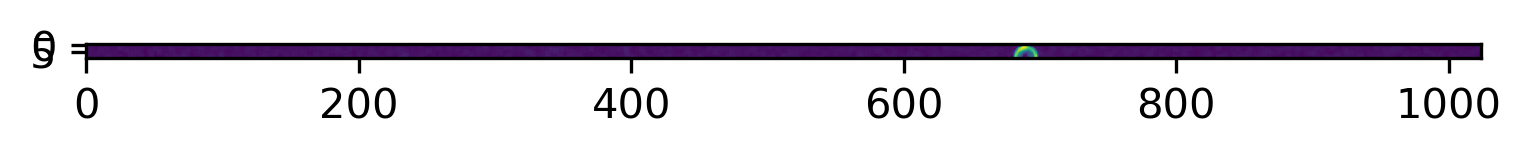

0 51


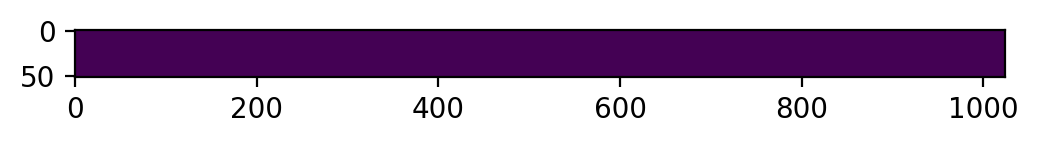

51 84


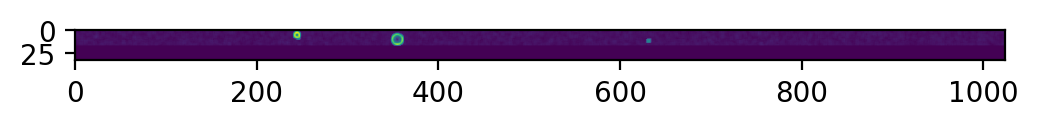

84 98


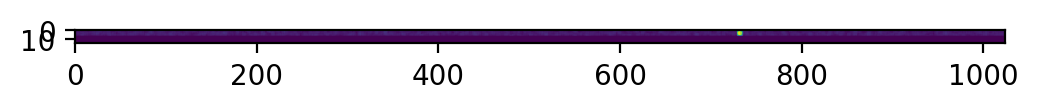

98 120


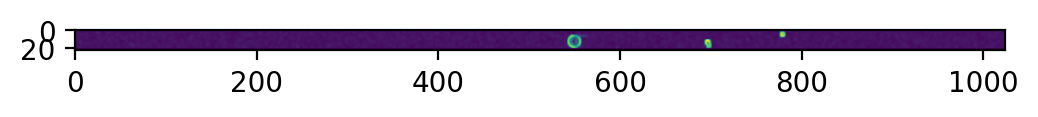

120 182


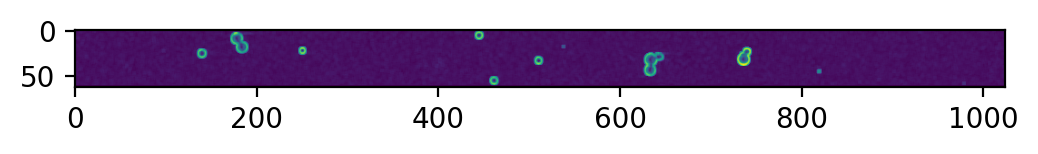

182 209


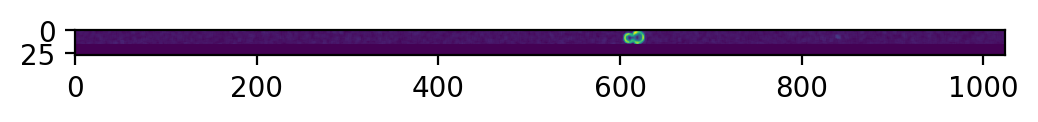

209 683


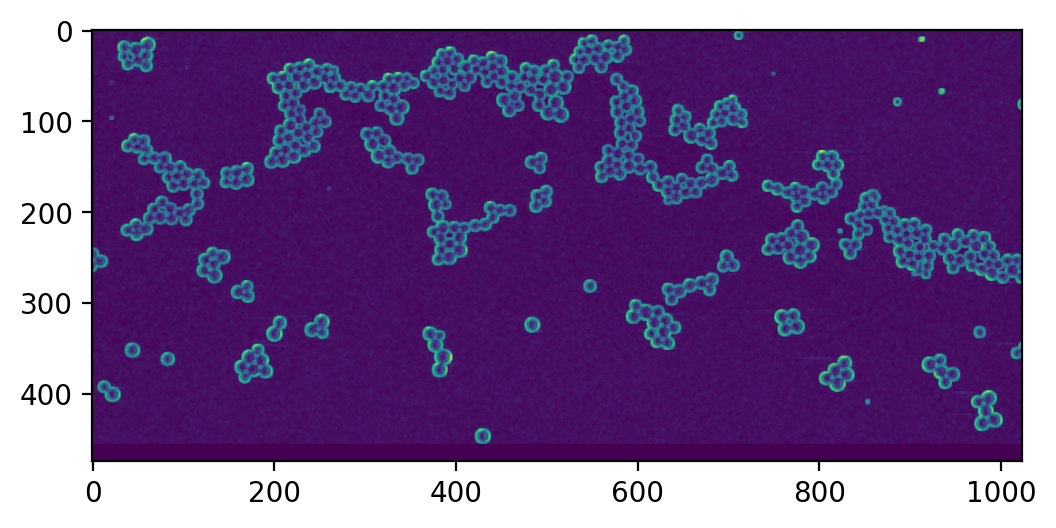

In [29]:
for i in range(1,len(x_borders)):
    plt.figure(dpi=200)
    print(x_borders[i-1],x_borders[i])
    plt.imshow(img[x_borders[i-1]:x_borders[i],:])
    plt.show()
    plt.close()